Using 16 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK', 'JNJ', 'LLY', 'MRK']...
OLS R2 train: 0.009 | test: -0.020
RF  R2 train: 0.038 | test: -0.012
RF grid best: {'max_depth': 5, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 300} | R2 test: -0.01223473600656555
7/7 MOM | profit: 118.604 | weekly r%: 1.759 | sigma: 1.820
RF        | profit: -136.229 | weekly r%: -2.020 | sigma: 1.917
OLS       | profit: -157.853 | weekly r%: -2.341 | sigma: 1.804


C:\Users\cooki\AppData\Local\Temp\ipykernel_7144\3947626961.py:293: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vals = ax.get_yticks(); ax.set_yticklabels([f"{v:.0%}" for v in vals])


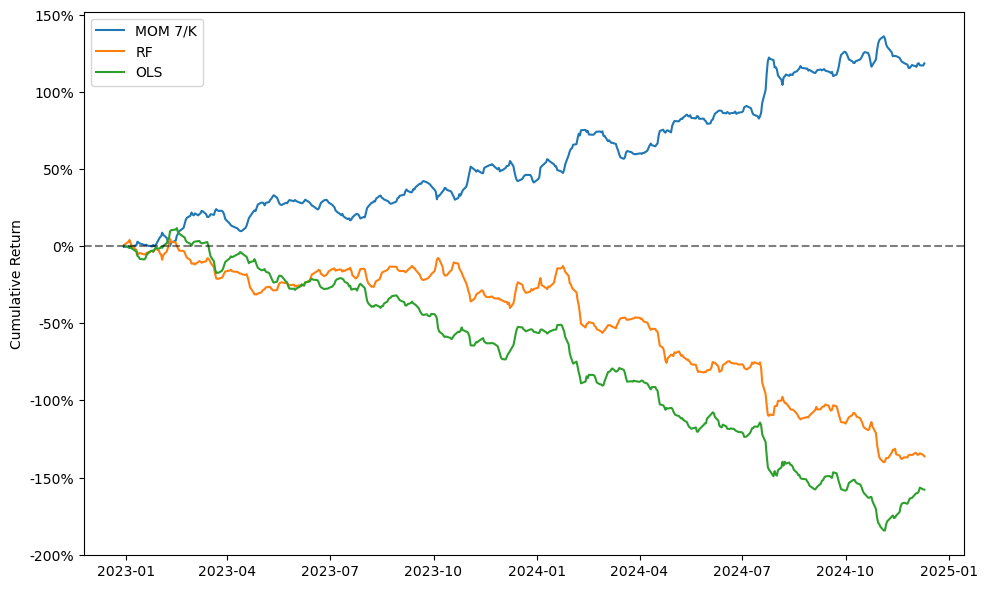

Max DD — MOM:-103.924% | RF:-3044.966% | OLS:-2223.580%


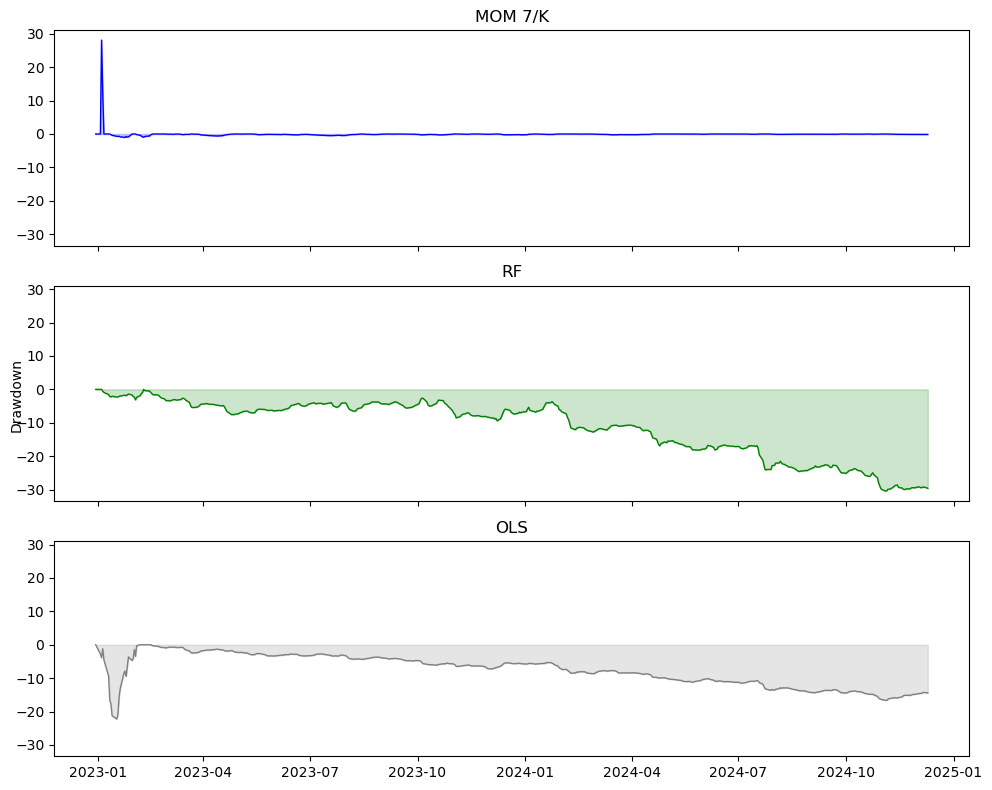

In [7]:
# ============================================
# Random-Forest predictor on local by_ticker_csv (index/date safe)
# ============================================
import os, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pandas.api.types import is_datetime64_any_dtype

# ----------------------------
# Config
# ----------------------------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS  = None          # e.g. ['ABBV','AMGN', ...]; keep None to auto-discover
START    = None          # e.g. datetime.datetime(2018,1,1)
END      = None          # e.g. datetime.datetime(2024,12,31)
K_HOLD   = 7             # holding period used for momentum evaluation
LOOKBACKS = (3,7,15,30)  # momentum feature lengths

# ----------------------------
# Helpers to keep 'Date' robust
# ----------------------------
def ensure_date_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a copy of df where a datetime column named 'Date' exists,
    whether the date was an index (named/unnamed) or already a column.
    """
    out = df.copy()
    if 'Date' in out.columns and is_datetime64_any_dtype(out['Date']):
        return out
    # If index is datetime -> move to a column
    if is_datetime64_any_dtype(out.index):
        out = out.reset_index()
        # After reset, the datetime column may be named 'index' or original index name
        dt_cols = [c for c in out.columns if is_datetime64_any_dtype(out[c])]
        if dt_cols:
            if 'Date' not in dt_cols:
                out = out.rename(columns={dt_cols[0]: 'Date'})
            return out
    # If any datetime column exists, rename first to 'Date'
    dt_cols = [c for c in out.columns if is_datetime64_any_dtype(out[c])]
    if dt_cols:
        if 'Date' not in dt_cols:
            out = out.rename(columns={dt_cols[0]: 'Date'})
        return out
    raise KeyError("No datetime column found to use as 'Date'.")

def find_date_col(df: pd.DataFrame) -> str:
    """Return the datetime column name to use as pivot index."""
    if 'Date' in df.columns and is_datetime64_any_dtype(df['Date']):
        return 'Date'
    for c in df.columns:
        if is_datetime64_any_dtype(df[c]):
            return c
    raise KeyError("No datetime column found.")

# ----------------------------
# IO helpers
# ----------------------------
def list_tickers(path):
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Data directory not found: {path}")
    return sorted(os.path.splitext(f)[0] for f in os.listdir(path) if f.lower().endswith(".csv"))

def load_one(ticker):
    p = os.path.join(DATA_DIR, f"{ticker}.csv")
    if not os.path.isfile(p): raise FileNotFoundError(p)
    df = pd.read_csv(p, parse_dates=["Date"]).sort_values("Date")
    if "Adj Close" not in df.columns:
        if "Close" not in df.columns:
            raise ValueError(f"{ticker}: missing Close/Adj Close")
        df["Adj Close"] = df["Close"]
    if "Volume" not in df.columns:
        df["Volume"] = np.nan
    df["Ticker"] = ticker
    return df[["Date","Ticker","Adj Close","Volume"]]

def get_data(tickers, start=None, end=None):
    frames = []
    for t in tickers:
        df = load_one(t)
        if start: df = df[df["Date"] >= pd.Timestamp(start)]
        if end:   df = df[df["Date"] <= pd.Timestamp(end)]
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# ----------------------------
# Feature engineering (index-safe using transform)
# ----------------------------
def prep_data(tickers, start=None, end=None, K=7):
    raw = get_data(tickers, start, end)

    # Wide price and returns
    px = raw.pivot(index="Date", columns="Ticker", values="Adj Close").sort_index()
    ret = px.pct_change()

    # Long per-asset table
    d = raw.rename(columns={"Adj Close":"Price"}).copy()

    # daily reversal (t-1) — aligned
    d["t-1"] = d.groupby("Ticker")["Price"].pct_change().shift(1)

    # momentum & volatility windows (use transform to keep original index)
    for L in LOOKBACKS:
        d[f"J_{L}"] = d.groupby("Ticker")["t-1"].transform(
            lambda s: (1 + s).rolling(L).apply(np.prod, raw=True) - 1
        )
        d[f"J_std_{L}"] = d.groupby("Ticker")["t-1"].transform(
            lambda s: (1 + s).rolling(L).std()
        )

    # forward K-day target — aligned
    d["target"] = d.groupby("Ticker")["Price"].shift(-K) / d["Price"] - 1

    # clean
    d = d.dropna().sort_values("Date").reset_index(drop=True)

    # index by Date for splitting
    d_idx = d.set_index("Date")
    d_idx.index.name = "Date"  # keep name to make reset_index stable
    return d, d_idx, ret, px

# ----------------------------
# Chronological split 80/20
# ----------------------------
def split_train_test(d_idx, px, test_ratio=0.2):
    common_dates = pd.Index(sorted(set(d_idx.index) & set(px.index)))
    if common_dates.empty:
        raise ValueError("No overlapping dates between features and prices.")
    cut = int(len(common_dates) * (1 - test_ratio)) or 1
    dates_train = common_dates[:cut]
    dates_test  = common_dates[cut:]

    train = d_idx.loc[dates_train]
    test  = d_idx.loc[dates_test]

    data_train = train.copy()
    data_test  = test.copy()

    drop_cols = ["Ticker","Price","target"]
    X_train = (train.drop(columns=drop_cols, errors="ignore")
                    .select_dtypes(include=[np.number])
                    .replace([np.inf,-np.inf], np.nan).fillna(0.0))
    y_train = train["target"].copy()
    X_test  = (test.drop(columns=drop_cols, errors="ignore")
                   .select_dtypes(include=[np.number])
                   .replace([np.inf,-np.inf], np.nan).fillna(0.0))
    y_test  = test["target"].copy()

    return X_train, y_train, X_test, y_test, data_train, data_test

# ----------------------------
# Momentum helpers (for comparison)
# ----------------------------
def Momentum(pred_r, date, K, px):
    ret = pred_r.loc[date].reset_index()
    ret["quantile"] = pd.qcut(ret.iloc[:,1].rank(method="first"), 3, labels=False)
    winners = ret[ret["quantile"] == 2]
    losers  = ret[ret["quantile"] == 0]
    next_date = date + relativedelta(days=K)
    if next_date not in px.index:
        return np.nan, np.nan, np.nan
    w = px.loc[next_date, px.columns.isin(winners.Ticker)] / px.loc[date, px.columns.isin(winners.Ticker)] - 1
    l = px.loc[next_date, px.columns.isin(losers.Ticker)]  / px.loc[date, px.columns.isin(losers.Ticker)]  - 1
    mom = w.mean() - l.mean()
    return (mom / K * 7), (w.mean() / K * 7), (-l.mean() / K * 7)

def MOM_Profit(returns, K, px):
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        m, win, los = Momentum(returns, date, K, px)
        if np.isnan(m): continue
        profits.append(m); wins.append(win); loss.append(los); dates.append(date)
    frame = pd.DataFrame({"MomentumProfit": profits, "Winners": wins, "Losers": loss}, index=dates) * 100
    return frame, frame.cumsum(), frame.MomentumProfit.sum()

# ----------------------------
# Robust prediction -> panel converter (no index alignment issues)
# ----------------------------
def attach_preds(model, X_train, X_test, data_train, data_test, name):
    y_pred_train = np.asarray(model.predict(X_train)).reshape(-1)
    y_pred_test  = np.asarray(model.predict(X_test)).reshape(-1)

    tr = ensure_date_column(data_train)
    dt = ensure_date_column(data_test)
    date_col_tr = find_date_col(tr)
    date_col_dt = find_date_col(dt)

    if len(tr) != len(y_pred_train):
        raise ValueError(f"[{name}] train rows ({len(tr)}) != train preds ({len(y_pred_train)})")
    if len(dt) != len(y_pred_test):
        raise ValueError(f"[{name}] test rows ({len(dt)}) != test preds ({len(y_pred_test)})")

    tr_pred = pd.DataFrame({
        "Date":   tr[date_col_tr].to_numpy(),
        "Ticker": tr["Ticker"].to_numpy(),
        f"{name}_pred": y_pred_train
    })
    dt_pred = pd.DataFrame({
        "Date":   dt[date_col_dt].to_numpy(),
        "Ticker": dt["Ticker"].to_numpy(),
        f"{name}_pred": y_pred_test
    })

    panel_train = tr_pred.pivot_table(index="Date", columns="Ticker", values=f"{name}_pred")
    panel_test  = dt_pred.pivot_table(index="Date", columns="Ticker", values=f"{name}_pred")
    return panel_test, panel_train

# ----------------------------
# Load + features + split
# ----------------------------
tickers = TICKERS or list_tickers(DATA_DIR)
print(f"Using {len(tickers)} tickers: {tickers[:10]}{'...' if len(tickers)>10 else ''}")

d_long, d_idx, daily_pct_change, daily_close_px = prep_data(tickers, START, END, K=K_HOLD)
X_train, y_train, X_test, y_test, data_train, data_test = split_train_test(d_idx, daily_close_px)

# Keep non-scaled copies (as in your inspiration)
X_train_nonscaled = X_train.copy()
X_test_nonscaled  = X_test.copy()

# Standardized versions (handy for other models)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# ============================
# OLS
# ============================
lr = LinearRegression().fit(X_train_nonscaled, y_train)
print(f"OLS R2 train: {lr.score(X_train_nonscaled, y_train):.3f} | test: {lr.score(X_test_nonscaled, y_test):.3f}")

# ============================
# Random Forest
# ============================
forest = RandomForestRegressor(
    n_estimators=450, max_features=3, max_depth=4,
    min_samples_split=3, min_samples_leaf=3,
    n_jobs=-1, random_state=42
)
forest.fit(X_train_nonscaled, y_train)
print(f"RF  R2 train: {forest.score(X_train_nonscaled, y_train):.3f} | test: {forest.score(X_test_nonscaled, y_test):.3f}")

# (optional) light grid
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [300],
    'max_features': [2, 3, 6],
    'max_depth': [5, 15],
    'min_samples_split': [5, 15],
    'min_samples_leaf': [5, 15],
}
grid = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3)
grid.fit(X_train_nonscaled, y_train)
print("RF grid best:", grid.best_params_, "| R2 test:", grid.score(X_test_nonscaled, y_test))

# ----------------------------
# Convert predictions to panels
# ----------------------------
RF_results, _  = attach_preds(forest, X_train_nonscaled, X_test_nonscaled, data_train, data_test, 'RF')
OLS_results, _ = attach_preds(lr,     X_train_nonscaled, X_test_nonscaled, data_train, data_test, 'OLS')

# ----------------------------
# Momentum comparison
# ----------------------------
tmp = ensure_date_column(data_test)
date_col = find_date_col(tmp)
MOM_7 = tmp.pivot_table(index=date_col, columns="Ticker", values="J_7")

MOM_7_frame, MOM_7_cum, MOM_7_profit = MOM_Profit(MOM_7, K_HOLD, daily_close_px)
RF_frame,  RF_cum,  RF_profit       = MOM_Profit(RF_results, K_HOLD, daily_close_px)
OLS_frame, OLS_cum, OLS_profit      = MOM_Profit(OLS_results, K_HOLD, daily_close_px)

print(f"7/{K_HOLD} MOM | profit: {MOM_7_profit:.3f} | weekly r%: {MOM_7_frame.MomentumProfit.mean()*7:.3f} | sigma: {MOM_7_frame.MomentumProfit.std():.3f}")
print(f"RF        | profit: {RF_profit:.3f} | weekly r%: {RF_frame.MomentumProfit.mean()*7:.3f} | sigma: {RF_frame.MomentumProfit.std():.3f}")
print(f"OLS       | profit: {OLS_profit:.3f} | weekly r%: {OLS_frame.MomentumProfit.mean()*7:.3f} | sigma: {OLS_frame.MomentumProfit.std():.3f}")

# ----------------------------
# Plot cumulative returns
# ----------------------------
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(MOM_7_cum.MomentumProfit/100, label='MOM 7/K')
ax.plot(RF_cum.MomentumProfit/100,    label='RF')
ax.plot(OLS_cum.MomentumProfit/100,   label='OLS')
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('Cumulative Return'); ax.legend()
vals = ax.get_yticks(); ax.set_yticklabels([f"{v:.0%}" for v in vals])
plt.tight_layout(); plt.show()

# ----------------------------
# Drawdowns
# ----------------------------
def DD(cum_series):
    hw = cum_series.cummax()
    dd = -((hw - cum_series) / hw).fillna(0)
    return dd, dd.min()

mom_dd, mom_mdd = DD(MOM_7_cum.MomentumProfit)
rf_dd,  rf_mdd  = DD(RF_cum.MomentumProfit)
ols_dd, ols_mdd = DD(OLS_cum.MomentumProfit)
print(f"Max DD — MOM:{mom_mdd:.3%} | RF:{rf_mdd:.3%} | OLS:{ols_mdd:.3%}")

fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True, sharey=True)
for a, dd, ttl, col in zip(ax, [mom_dd, rf_dd, ols_dd], ['MOM 7/K','RF','OLS'], ['b','g','gray']):
    a.plot(dd, color=col, linewidth=1); a.fill_between(dd.index, dd, 0, alpha=0.2, color=col); a.set_title(ttl)
fig.text(0.01, 0.5, 'Drawdown', va='center', rotation='vertical')
plt.tight_layout(); plt.show()
